In [ ]:
import os
import torch
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm.auto import tqdm
import kagglehub

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
path = kagglehub.dataset_download("abdelghaniaaba/wildfire-prediction-dataset")

Using Colab cache for faster access to the 'wildfire-prediction-dataset' dataset.


In [ ]:
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/wildfire-prediction-dataset


In [ ]:
train_dir = f'{path}/train'
valid_dir = f'{path}/valid'
test_dir = f'{path}/test'

In [ ]:
img_size = 224
root_dir = 'data'
batch_size = 32

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
])

eval_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

transforms.RandomHorizontalFlip(),
train_ds = datasets.ImageFolder(os.path.join(path, "train"), transform=train_tf, loader=lambda x: Image.open(x).convert("RGB"))
val_ds   = datasets.ImageFolder(os.path.join(path, "valid"),   transform=eval_tf, loader=lambda x: Image.open(x).convert("RGB"))
test_ds  = datasets.ImageFolder(os.path.join(path, "test"),  transform=eval_tf, loader=lambda x: Image.open(x).convert("RGB"))


loaders = {
    "train": DataLoader(train_ds, batch_size=batch_size, shuffle=True,),
    "val":   DataLoader(val_ds,   batch_size=batch_size, shuffle=False,),
    "test":  DataLoader(test_ds,  batch_size=batch_size, shuffle=False,)
}

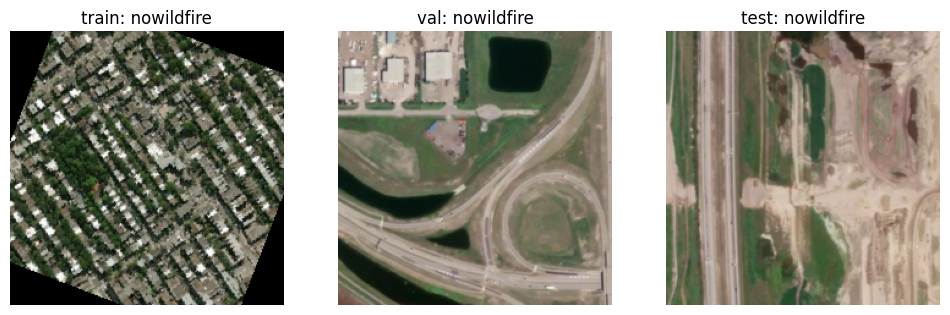

In [ ]:
import random
import matplotlib.pyplot as plt

def show_random_sample(loaders, class_names=None):
    """
    TO DO
    """

    splits = ["train", "val", "test"]

    plt.figure(figsize=(12, 4))

    for i, split in enumerate(splits, 1):
        loader = loaders[split]
        images, labels = next(iter(loader))

        idx = random.randint(0, len(images) - 1)
        img  = images[idx]
        label = labels[idx].item()

        img = img.permute(1, 2, 0).numpy()

        plt.subplot(1, 3, i)
        plt.imshow(img)
        if class_names:
            plt.title(f"{split}: {class_names[label]}")
        else:
            plt.title(f"{split}: class {label}")
        plt.axis("off")

    plt.show()


class_names = loaders["train"].dataset.classes

show_random_sample(loaders, class_names)

In [ ]:
print(loaders["train"].dataset)
print(loaders["val"].dataset)
print(loaders["test"].dataset)

Dataset ImageFolder
    Number of datapoints: 30250
    Root location: /kaggle/input/wildfire-prediction-dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 6300
    Root location: /kaggle/input/wildfire-prediction-dataset/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 6300
    Root location: /kaggle/input/wildfire-prediction-dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=

In [ ]:
import torch.nn as nn
import timm

swim_models = timm.list_models('*swin*')
print(swim_models)

['hiera_base_abswin_256', 'hiera_small_abswin_256', 'swin_base_patch4_window7_224', 'swin_base_patch4_window12_384', 'swin_large_patch4_window7_224', 'swin_large_patch4_window12_384', 'swin_s3_base_224', 'swin_s3_small_224', 'swin_s3_tiny_224', 'swin_small_patch4_window7_224', 'swin_tiny_patch4_window7_224', 'swinv2_base_window8_256', 'swinv2_base_window12_192', 'swinv2_base_window12to16_192to256', 'swinv2_base_window12to24_192to384', 'swinv2_base_window16_256', 'swinv2_cr_base_224', 'swinv2_cr_base_384', 'swinv2_cr_base_ns_224', 'swinv2_cr_giant_224', 'swinv2_cr_giant_384', 'swinv2_cr_huge_224', 'swinv2_cr_huge_384', 'swinv2_cr_large_224', 'swinv2_cr_large_384', 'swinv2_cr_small_224', 'swinv2_cr_small_384', 'swinv2_cr_small_ns_224', 'swinv2_cr_small_ns_256', 'swinv2_cr_tiny_224', 'swinv2_cr_tiny_384', 'swinv2_cr_tiny_ns_224', 'swinv2_large_window12_192', 'swinv2_large_window12to16_192to256', 'swinv2_large_window12to24_192to384', 'swinv2_small_window8_256', 'swinv2_small_window16_256',

In [ ]:
model = timm.create_model(
    'swin_tiny_patch4_window7_224',
    pretrained=True,
    num_classes=1
)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = True

In [ ]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

769


In [ ]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Train", leave=False)

    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        outputs = model(imgs).squeeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

        preds = (outputs > 0).long()

        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total



def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validate", leave=False)
        for imgs, labels in pbar:
            imgs = imgs.to(device)
            labels = labels.to(device).float()

            outputs = model(imgs).squeeze(1)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)

            preds = (outputs > 0).long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


In [ ]:
for _, labels in loaders['train']:
    print(labels.unique())
    break


tensor([0, 1])


In [ ]:
epochs = 10

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

best_val_acc = 0.0
best_path = "best_model.pt"

model = model.to(device)

for epoch in range(1, epochs + 1):

    train_loss, train_acc = train_one_epoch(
        model, loaders["train"], optimizer, criterion, device
    )

    val_loss, val_acc = validate(
        model, loaders["val"], criterion, device
    )

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f">>> Saved best model! (val_acc={val_acc:.4f})")

    print(f"Epoch {epoch}/{epochs} "
          f"| Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}"
          f"| Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")


Train:   0%|          | 0/946 [00:00<?, ?it/s]

Validate:   0%|          | 0/197 [00:00<?, ?it/s]

>>> Saved best model! (val_acc=0.9130)
Epoch 1/10 | Train Loss: 0.3626 Acc: 0.8940| Val Loss: 0.2567 Acc: 0.9130


Train:   0%|          | 0/946 [00:00<?, ?it/s]

Validate:   0%|          | 0/197 [00:00<?, ?it/s]

>>> Saved best model! (val_acc=0.9283)
Epoch 2/10 | Train Loss: 0.2229 Acc: 0.9198| Val Loss: 0.2125 Acc: 0.9283


Train:   0%|          | 0/946 [00:00<?, ?it/s]

Validate:   0%|          | 0/197 [00:00<?, ?it/s]

>>> Saved best model! (val_acc=0.9357)
Epoch 3/10 | Train Loss: 0.1931 Acc: 0.9310| Val Loss: 0.1912 Acc: 0.9357


Train:   0%|          | 0/946 [00:00<?, ?it/s]

Validate:   0%|          | 0/197 [00:00<?, ?it/s]

>>> Saved best model! (val_acc=0.9402)
Epoch 4/10 | Train Loss: 0.1785 Acc: 0.9359| Val Loss: 0.1791 Acc: 0.9402


Train:   0%|          | 0/946 [00:00<?, ?it/s]

Validate:   0%|          | 0/197 [00:00<?, ?it/s]

>>> Saved best model! (val_acc=0.9443)
Epoch 5/10 | Train Loss: 0.1683 Acc: 0.9402| Val Loss: 0.1659 Acc: 0.9443


Train:   0%|          | 0/946 [00:00<?, ?it/s]

Validate:   0%|          | 0/197 [00:00<?, ?it/s]

>>> Saved best model! (val_acc=0.9449)
Epoch 6/10 | Train Loss: 0.1612 Acc: 0.9424| Val Loss: 0.1616 Acc: 0.9449


Train:   0%|          | 0/946 [00:00<?, ?it/s]

Validate:   0%|          | 0/197 [00:00<?, ?it/s]

>>> Saved best model! (val_acc=0.9470)
Epoch 7/10 | Train Loss: 0.1565 Acc: 0.9449| Val Loss: 0.1547 Acc: 0.9470


Train:   0%|          | 0/946 [00:00<?, ?it/s]

Validate:   0%|          | 0/197 [00:00<?, ?it/s]

>>> Saved best model! (val_acc=0.9489)
Epoch 8/10 | Train Loss: 0.1509 Acc: 0.9458| Val Loss: 0.1508 Acc: 0.9489


Train:   0%|          | 0/946 [00:00<?, ?it/s]

Validate:   0%|          | 0/197 [00:00<?, ?it/s]

>>> Saved best model! (val_acc=0.9490)
Epoch 9/10 | Train Loss: 0.1490 Acc: 0.9478| Val Loss: 0.1441 Acc: 0.9490


Train:   0%|          | 0/946 [00:00<?, ?it/s]

Validate:   0%|          | 0/197 [00:00<?, ?it/s]

>>> Saved best model! (val_acc=0.9510)
Epoch 10/10 | Train Loss: 0.1442 Acc: 0.9487| Val Loss: 0.1408 Acc: 0.9510


In [ ]:
print(model)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

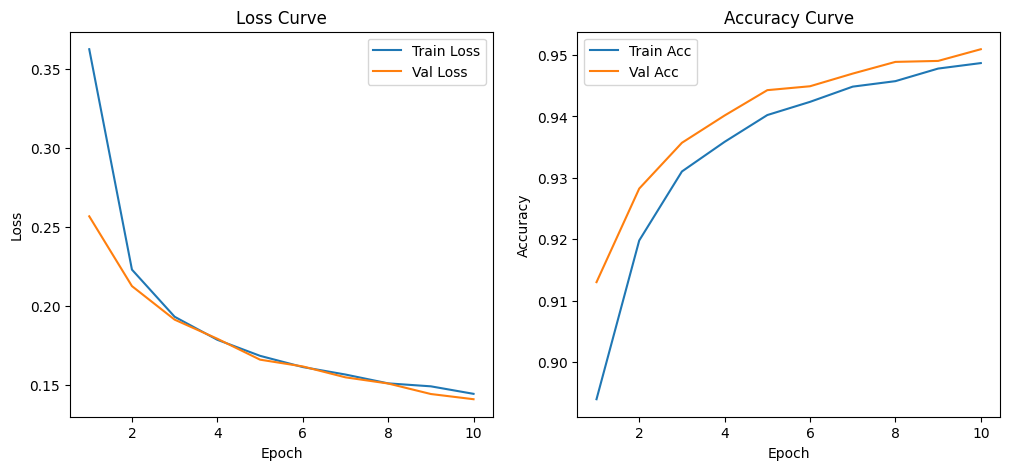

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="Train Acc")
plt.plot(epochs_range, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


In [ ]:
import torch
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_auc(model, dataloader, device):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            all_labels.append(labels.cpu().numpy())

            if outputs.shape[1] == 1:
                probs = torch.sigmoid(outputs).cpu().numpy()
            else:
                probs = torch.softmax(outputs, dim=1).cpu().numpy()

            all_scores.append(probs)

    y_true = np.concatenate(all_labels)
    y_scores = np.concatenate(all_scores)


    if y_scores.ndim == 2 and y_scores.shape[1] == 1:
        y_scores = y_scores.ravel()

        fpr, tpr, _ = roc_curve(y_true, y_scores)
        auc_score = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Binary)")
        plt.legend()
        plt.grid()
        plt.show()
        return


    n_classes = y_scores.shape[1]
    y_true_oh = np.eye(n_classes)[y_true]

    plt.figure(figsize=(8, 6))

    for c in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_oh[:, c], y_scores[:, c])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Classe {c} (AUC = {auc_score:.4f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend()
    plt.grid()
    plt.show()


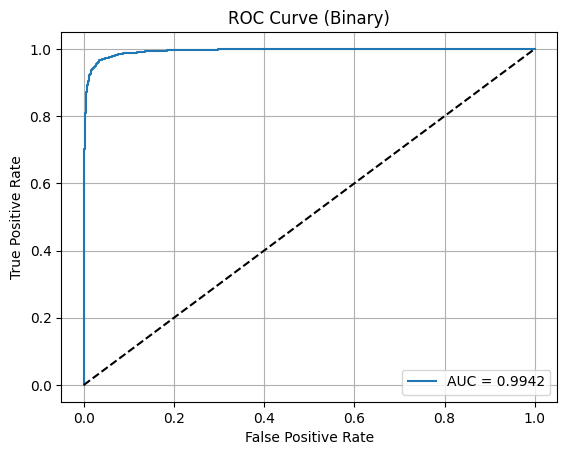

In [ ]:
plot_roc_auc(model, loaders["test"], device)

In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

def precision_recall_f1(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x, labels in dataloader:
            x = x.to(device)
            labels = labels.to(device)

            outputs = model(x)

            if outputs.ndim == 2 and outputs.shape[1] > 1:
                preds = torch.argmax(outputs, dim=1)
            else:
                preds = (torch.sigmoid(outputs) > 0.5).long().squeeze()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return precision, recall, f1


In [ ]:
precision, recall, f1 = precision_recall_f1(model, loaders["test"], device)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Precision: 0.9608
Recall:    0.9630
F1-score:  0.9617


In [ ]:
test_loss, test_acc = validate(model, loaders["test"], criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Validate:   0%|          | 0/197 [00:00<?, ?it/s]

Test Loss: 0.1155 | Test Acc: 0.9621


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader, device, class_names=None):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1)

            outputs = model(inputs)

            # BINÁRIO: sigmoid + threshold 0.5
            if outputs.ndim == 1 or outputs.shape[1] == 1:
                probs = torch.sigmoid(outputs).view(-1)
                preds = (probs > 0.5).long()

            # MULTICLASSE: softmax + argmax
            else:
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)

    # matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # nomes das classes
    if class_names is None:
        n_classes = cm.shape[0]
        class_names = [f"Classe {i}" for i in range(n_classes)]

    # plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    # plt.title("Confusion Matrix")
    plt.show()


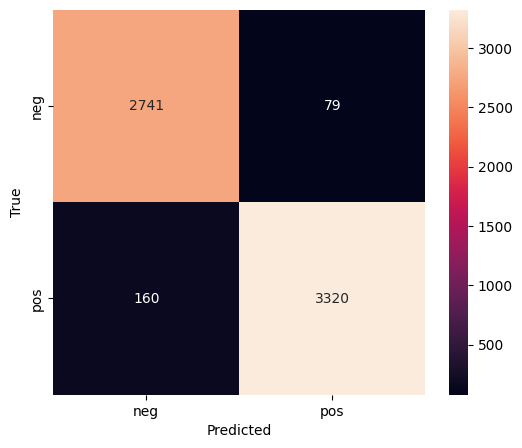

In [ ]:
plot_confusion_matrix(model, loaders["test"], device, class_names=["neg", "pos"])